In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

# Libraries and imports

Here I'm importing all libs that will be used by me in this notebook.

In [2]:
# Python's libs
%matplotlib inline
import glob
import os
import warnings

# Tools libs
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

# Machine Learning libs
from keras.utils.vis_utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Helpers developed by me
from helpers import metrics, plot_training, load_images

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

# Dataset
![Optional Text](./images/dataset_sample.png)

## Sources 
- This dataset was taken from the Kaggle platform posted here in this [link](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

Also, you can add more dataset to improve the Deep Learning model, there are many datasets similar in the Kaggle that combine can create a huge base of knowledge for this application. Although the focus here is to create a Proof of Concept (POC).

## Information
- There are 2 main folders:
    - raw -> Images not processed, in original format;
    - transformed -> Images processed, in format 250, 250, 1 (Gray);


The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). 

## Summary

To explain the labels and counts of the dataset (metadata):
- **image_name**: the file's name.
- **full_path_raw**: the full path to the raw image.
- **full_path_transformed**: the full path to the transformed image.
- **kind**: how will be used the file train, test, and val.
- **flag**: flag that define the class, 0 means normal and 1 means pneumonia.


In [3]:
DATASET_DIR = "data/data_image.csv"
dataset = pd.read_csv(DATASET_DIR)
dataset.head()

image_name                               full_path_raw  \
0     IM-0509-0001-0001.jpeg     raw/train/NORMAL/IM-0509-0001-0001.jpeg   
1  NORMAL2-IM-0836-0001.jpeg  raw/train/NORMAL/NORMAL2-IM-0836-0001.jpeg   
2          IM-0737-0001.jpeg          raw/train/NORMAL/IM-0737-0001.jpeg   
3  NORMAL2-IM-0396-0001.jpeg  raw/train/NORMAL/NORMAL2-IM-0396-0001.jpeg   
4          IM-0182-0001.jpeg          raw/train/NORMAL/IM-0182-0001.jpeg   

                               full_path_transformed   kind  flag  
0    transformed/train/NORMAL/IM-0509-0001-0001.jpeg  train     0  
1  transformed/train/NORMAL/NORMAL2-IM-0836-0001....  train     0  
2         transformed/train/NORMAL/IM-0737-0001.jpeg  train     0  
3  transformed/train/NORMAL/NORMAL2-IM-0396-0001....  train     0  
4         transformed/train/NORMAL/IM-0182-0001.jpeg  train     0

<IPython.core.display.Javascript object>

In [4]:
%%time
IMAGE_RESOLUTION = (250, 250, 1)
print('Image shape: {}'.format(IMAGE_RESOLUTION))


# Creating dataset
train_set = dataset[dataset.kind == "train"][["full_path_transformed", "flag"]]
test_set = dataset[dataset.kind == "test"][["full_path_transformed", "flag"]]
val_set = dataset[dataset.kind == "val"][["full_path_transformed", "flag"]]

# Creating X and y variables
X_train, y_train = load_images(train_set, IMAGE_RESOLUTION)
X_test, y_test = load_images(test_set, IMAGE_RESOLUTION)
X_val, y_val = load_images(val_set, IMAGE_RESOLUTION)

# Infortmations
print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Image shape: (250, 250, 1)
Train data shape: (5216, 250, 250, 1), Labels shape: (5216,)
Test data shape: (624, 250, 250, 1), Labels shape: (624,)
Validation data shape: (16, 250, 250, 1), Labels shape: (16,)
Wall time: 10.4 s


<IPython.core.display.Javascript object>

### Examples

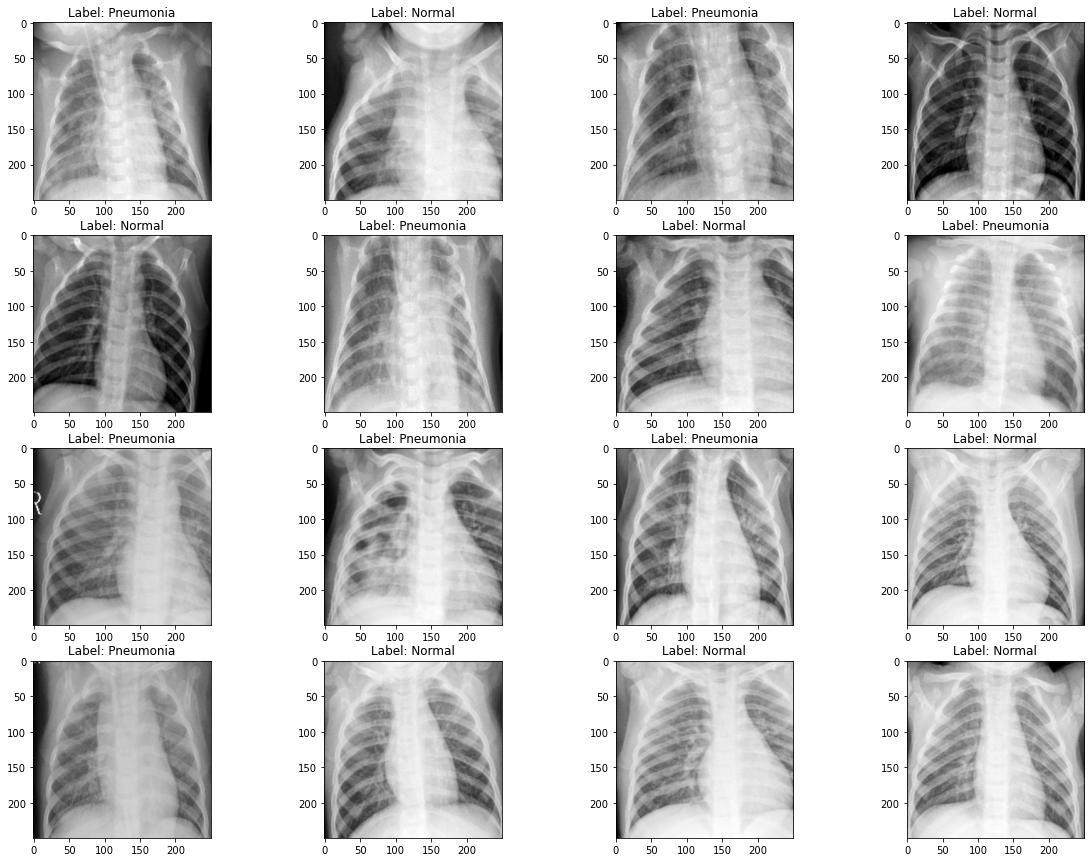

<IPython.core.display.Javascript object>

In [5]:
labels = ["Pneumonia" if y else "Normal" for y in y_val]
plt.figure(figsize=(20, 15))
for i, x in enumerate(X_val):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x.reshape(IMAGE_RESOLUTION), "gray")
    plt.axis("on")
    plt.title("Label: {}".format(labels[i]))

Where is our focus on these images?
<br/>
<br/>
<br/>
<div style="center center; width: 250px; height 250px;">
    <img src="images/region_of_interest.PNG" />
</div>
<br/>
<br/>
We must keep our CNN look at the chest region of the image, where is the important to define if a person has pneumonia or not.

### ImageDataGenerator
Generate batches of tensor image data with real-time data augmentation.

In [6]:
# Define generator
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=False,
    vertical_flip=False,
)

# Fit generator on our train features
datagen.fit(X_train)

<IPython.core.display.Javascript object>

# Model
We are using Convolutional Neural Network as a model to learn from our dataset to be a specialist model in predict pneumonia.

The models are defined in the folder **models** and will be imported and executed.
At the moment there are 3 different models available:
- cnn5_ann5_fibonacci_adam
- cnn6_ann3_pow10_adamax
- cnn10_ann2_pow2_adam

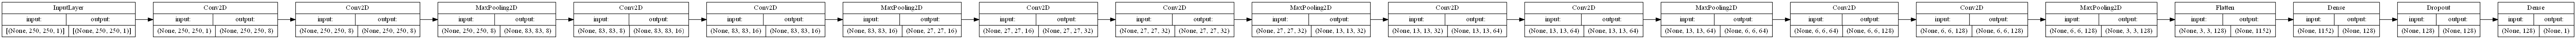

<IPython.core.display.Javascript object>

In [7]:
# Imports
from models.cnn5_ann5_fibonacci_adam.model import cnn5_ann5_fibonacci_adam
from models.cnn6_ann3_pow10_adamax.model import cnn6_ann3_pow10_adamax
from models.cnn10_ann2_pow2_adam.model import cnn10_ann2_pow2_adam


# Models
model = cnn10_ann2_pow2_adam(IMAGE_RESOLUTION)

# Will be used to save model and plots
model_path = os.path.join("models", "cnn10_ann2_pow2_adam")

# Saving the model's plot
plot_model(
    model,
    to_file=os.path.join(model_path, "model_plot.png"),
    show_shapes=True,
    show_layer_names=False,
    dpi=100,
    rankdir="LR",
)

### Class Weight
Due a imbalanced class we shoud compensate defining the **class_weight**.

In [8]:
COUNT_NORMAL = train_set.flag.value_counts().loc[0]
COUNT_PNEUMONIA = train_set.flag.value_counts().loc[1]

TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 1.9448173005219984, 1: 0.6730322580645162}

<IPython.core.display.Javascript object>

### Training
Here we are going to start the training process using the **model.fit( )**.

In [9]:
%%time
# EarlyStopping to stop our trainig process when is not nescessary keep training 
callback = EarlyStopping(monitor="loss", patience=3)

# Model fit return the historical metrics of it
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=5),
    validation_data=(X_test, y_test),
    epochs=100,
    verbose=1,
    callbacks=[callback],
    class_weight=class_weight
)

Epoch 1/100
1044/1044 [==============================] - 30s 24ms/step - loss: 0.5868 - accuracy: 0.5900 - val_loss: 0.4546 - val_accuracy: 0.7869
Epoch 2/100
1044/1044 [==============================] - 24s 23ms/step - loss: 0.4428 - accuracy: 0.7721 - val_loss: 0.4072 - val_accuracy: 0.8125
Epoch 3/100
1044/1044 [==============================] - 23s 22ms/step - loss: 0.4283 - accuracy: 0.7879 - val_loss: 0.3757 - val_accuracy: 0.8301
Epoch 4/100
1044/1044 [==============================] - 23s 22ms/step - loss: 0.3990 - accuracy: 0.8085 - val_loss: 0.4238 - val_accuracy: 0.8205
Epoch 5/100
1044/1044 [==============================] - 23s 22ms/step - loss: 0.3623 - accuracy: 0.8430 - val_loss: 0.4601 - val_accuracy: 0.8013
Epoch 6/100
1044/1044 [==============================] - 23s 22ms/step - loss: 0.3507 - accuracy: 0.8399 - val_loss: 0.4611 - val_accuracy: 0.8077
Epoch 7/100
1044/1044 [==============================] - 23s 22ms/step - loss: 0.3549 - accuracy: 0.8381 - val_loss: 0

<IPython.core.display.Javascript object>

### Metrics

Generating the training metrics shuch as accuracy, recal, precision, f1 score, and confusion matrix.

In [10]:
# Predicting the classes model
y_pred = model.predict(X_test, batch_size=4)

# Predicting the classes model
y_pred_class = y_pred.round()

# Plot training line
plot_training(history, model_path)

# Plot the metrics
metrics(
    y_test,
    y_pred.reshape(1, -1)[0],
    y_pred_class.reshape(1, -1)[0].astype(int),
    model_path,
)

<IPython.core.display.Javascript object>

Just to Save the model in the folder

In [11]:
model.save(os.path.join(model_path, "model"))

INFO:tensorflow:Assets written to: models\cnn10_ann2_pow2_adam\model\assets


<IPython.core.display.Javascript object>

Just to load the model from a folder

In [12]:
# from tensorflow import keras

# model = keras.models.load_model(os.path.join("app","model"))

<IPython.core.display.Javascript object>

# Explainability of Artificial Inteligence XAI

Explainable AI (XAI) is artificial intelligence (AI) in which the results of the solution can be understood by humans. It contrasts with the concept of the "black box" in machine learning where even its designers cannot explain why an AI arrived at a specific decision. XAI may be an implementation of the social right to explanation.

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions (see papers for details and citations).

You can check the docs here in this [link](https://github.com/slundberg/shap).

In [13]:
# Creating a string list with the labels
labels = ["Real Pneumonia" if y else "Real Normal" for y in y_val]
labels = pd.DataFrame(labels, columns=["Labels"])

# Getting the predictions using numpy
predictions = model.predict(X_val).round().reshape(-1, 1).astype(int)
labels["Predictions"] = [
    "Predicted Pneumonia" if y else "Predicted Normal" for y in predictions
]
labels["Print Real - Predicted"] = labels["Labels"].str.cat(
    labels["Predictions"], sep=" - "
)

# The columns with both information
labels_to_print = labels["Print Real - Predicted"].values.reshape(-1, 1)
labels.head()

Labels          Predictions                Print Real - Predicted
0  Real Pneumonia  Predicted Pneumonia  Real Pneumonia - Predicted Pneumonia
1     Real Normal  Predicted Pneumonia     Real Normal - Predicted Pneumonia
2  Real Pneumonia  Predicted Pneumonia  Real Pneumonia - Predicted Pneumonia
3     Real Normal     Predicted Normal        Real Normal - Predicted Normal
4     Real Normal     Predicted Normal        Real Normal - Predicted Normal

<IPython.core.display.Javascript object>

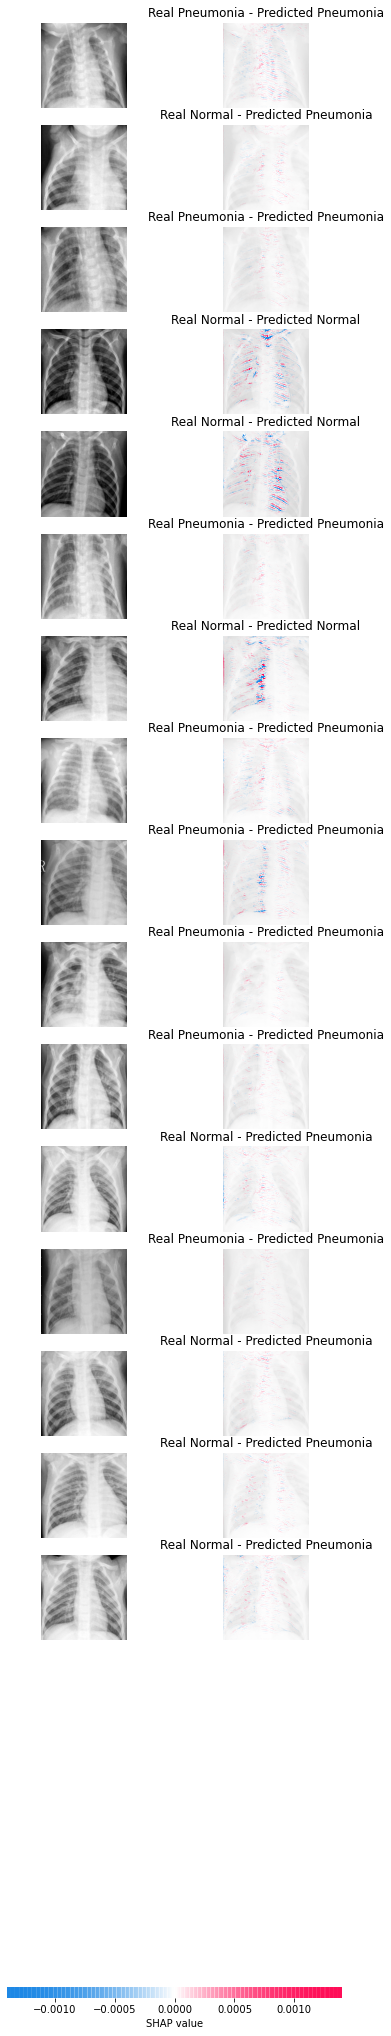

<IPython.core.display.Javascript object>

In [14]:
# Creating the explainer object that will be used by the model
e = shap.DeepExplainer(model, X_val)

# The shap values is the explainer values
shap_values = e.shap_values(X_val)

# Plot the image explaining the predictions
fig = shap.image_plot(shap_values, X_val, labels=labels_to_print, show=False)

# Saving the image
plt.savefig(model_path + "/shap.jpeg")